# Experimental feature: Content classification with confidence scores
Rami Ariss, April 13th 2022

Google Cloud Natural Language API has a content classification feature that, given text, returns content categories with their confidence rankings.

My hypothesis is that limericks with high subject continuity should have content classification categories with high confidence. This notebook implements the Google Natural Language API to classify limericks.

NOTE: This requires setting up a Google Cloud billing account, and the service is NOT free after the first 30k content classification API hits.

Resources:
- [Google Natural Language: Classify text tutorial](https://cloud.google.com/natural-language/docs/classify-text-tutorial)
- [Google Natural Language Pricing](https://cloud.google.com/natural-language/pricing)

# Notebook Preparation

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install --upgrade google-cloud-language

In [2]:
import argparse
import io
import json
import os

from google.cloud import language
import numpy
import six
import pandas as pd
import numpy as np
import scipy
import time

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer

In [4]:
# Replace path with the path of the JSON file that contains your service account key.
credential_fpath = '/content/automatic-poetry-generation-85e59269832f.json'
!gcloud auth activate-service-account --key-file $credential_fpath
!pip install --upgrade -q google-cloud-vision

Activated service account credentials for: [idl-001@automatic-poetry-generation.iam.gserviceaccount.com]


In [5]:
%env GOOGLE_APPLICATION_CREDENTIALS=$credential_fpath

env: GOOGLE_APPLICATION_CREDENTIALS=/content/automatic-poetry-generation-85e59269832f.json


# Data

Limerick files can be found under `/data/raw` in the github repository. I have this mounted in my Google Drive as well.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
DATA_DIR = 'drive/MyDrive/11-785_IDL/automatic_poetry_generation/data'
!ls $DATA_DIR

classification	preprocessing  raw


## Load OEDILF Limericks

In [105]:
def json_poems(fname):
  """Cleans up poems in the parsed jsons format into a list of strings"""
  f = open(fname)
  poems_json = json.load(f)
  
  poems = []
  for k, p in poems_json['limericks'].items():
    poems.append(p['lines'])

  return poems_json, poems

In [106]:
oedilf_fpath = os.path.join(DATA_DIR, 'preprocessing/limericks.json')
oedilf_poems_json, oedilf_poems = json_poems(oedilf_fpath)

In [107]:
oedilf_poems[0]

["cap'n jack was washed over the side.",
 'his crew searched but found not hair nor hide.',
 'no longer the helm,',
 'but the deep benthic realm,',
 'is where jack will forever reside.']

In [183]:
oedilf_fpath = os.path.join(DATA_DIR, 'raw/oedilf_lexical_diversity.json')
oedilf_poems = generated_poems_json(oedilf_fpath)

# Filtered Generated Free Form Poems

In [26]:
def generated_poems_json(fname):
  """Reads in generated poems into a list of strings"""
  # load_json
  with open(fname) as f:
    poems = json.load(f)

  return poems

In [98]:
filtered_free_form_fpath = os.path.join(DATA_DIR, 'raw/04_21_free_form_spell_checked_12832_ld_10702.json')
filtered_free_form_poems = generated_poems_json(filtered_free_form_fpath)

## Generated Poems

In [ ]:
def generated_poems(fname):
  """Cleans up generated poems and into a list of strings"""
  # read file
  with open(fname) as f:
    lines = f.readlines()
  
  # parse into list of poems
  poems = [[]]
  i = 0  # limerick index
  for l in lines:
    l = l.strip()  # remove '\n'
    # if empty line (new limerick)
    if len(l) == 0:
      poems.append([])
      i += 1
    else:
      poems[i].append(l)
  poems = poems[:-1] # exclude last blank

  return poems

In [ ]:
free_form_fpath = os.path.join(DATA_DIR, 'raw/free_form_5000.txt')
free_form_poems = generated_poems(free_form_fpath)

In [ ]:
free_form_poems[1]

["we're divorced. my love's completely unplanned",
 "i've cheated and i've got it on hand",
 'but she wants me to say',
 'gotta get it all day',
 "she's the next time for what i had planned"]

# Content Classification

In [35]:
def classify(text, verbose=True):
    """Classify the input text into categories."""

    language_client = language.LanguageServiceClient()

    document = language.Document(
        content=text, type_=language.Document.Type.PLAIN_TEXT
    )
    response = language_client.classify_text(request={"document": document})
    print(response)
    categories = response.categories

    result = {}

    for category in categories:
        # Turn the categories into a dictionary of the form:
        # {category.name: category.confidence}, so that they can
        # be treated as a sparse vector.
        result[category.name] = category.confidence

    if verbose:
        print(text)
        for category in categories:
            print("=" * 20)
            print("{:<16}: {}".format("category", category.name))
            print("{:<16}: {}".format("confidence", category.confidence))

    return result

In [37]:
text = " ".join(list(filtered_free_form_poems.values())[1])
text

"when your job as a dentist is rough, there's the root that comes next to the stuff of sandstone. it's ground, from a drill. this is found which shouldn't teach you who don't want to doff."

In [38]:
result = classify(text)
result

categories {
  name: "/Health/Oral & Dental Care"
  confidence: 0.6000000238418579
}

when your job as a dentist is rough, there's the root that comes next to the stuff of sandstone. it's ground, from a drill. this is found which shouldn't teach you who don't want to doff.
category        : /Health/Oral & Dental Care
confidence      : 0.6000000238418579


{'/Health/Oral & Dental Care': 0.6000000238418579}

In [ ]:
def classify_poems(poems, verbose=False, check_freq=100):
  "Classify a list of poems into categories"

  language_client = language.LanguageServiceClient()

  # flatten the poems into a single line each
  if isinstance(poems, list):
    flat_poems = list(map(lambda p: ' '.join(p), poems)) # classification seems better without punctuation
  else:
    print('ERROR: POEMS MUST BE OF TYPE LIST')

  results = []
  for i, text in enumerate(flat_poems):
    if (i % (check_freq)-1) == 0:
      print(f'Classifying poem {i}')
   
    document = language.Document(
        content=text, type_=language.Document.Type.PLAIN_TEXT
    )
    
    result = {}
    try:
      response = language_client.classify_text(request={"document": document})
      categories = response.categories

      for category in categories:
          # Turn the categories into a dictionary of the form:
          # {category.name: category.confidence}, so that they can
          # be treated as a sparse vector.
          result[category.name] = category.confidence

      if verbose:
          print(text)
          for category in categories:
              print("=" * 20)
              print("{:<16}: {}".format("category", category.name))
              print("{:<16}: {}".format("confidence", category.confidence))
    except:
      print(f'ERROR poem {i}: {text}')
    
    results.append(result)

  return flat_poems, results

In [185]:
def classify_poems_dict(poems, verbose=False, check_freq=100, max_tries=5, pause_length=2):
  "Classify a list of poems into categories"

  language_client = language.LanguageServiceClient()

  results = {}
  for i, (k, v) in enumerate(poems.items()):
    text = v['poem']
    if ((i+1) % check_freq) == 0:
      print(f'Classifying poem {i}')
   
    document = language.Document(
        content=' '.join(text), type_=language.Document.Type.PLAIN_TEXT
    )  # pass in flattened poem with no punctuation
    
    result = None
    for t in range(max_tries):
        pause = t * pause_length
        try:
          time.sleep(pause) 
          response = language_client.classify_text(request={"document": document})
          categories = response.categories
          result = {}
          for category in categories:
              # Turn the categories into a dictionary of the form:
              # {category.name: category.confidence}, so that they can
              # be treated as a sparse vector.
              result[category.name] = category.confidence

          if verbose:
              print('\n'.join(text))
              for category in categories:
                  print("=" * 20)
                  print("{:<16}: {}".format("category", category.name))
                  print("{:<16}: {}".format("confidence", category.confidence))
          break
        except Exception:
          print(i, k, text, Exception)
          continue
    
    # results[k] = {
    #     'poem': '\n'.join(text),
    #     'class': result
    # }
    
    results[k] = v.copy()
    results[k].update({
        'poem': '\n'.join(text),
        'class': result
        })

  return results

In [53]:
results = classify_poems_dict(filtered_free_form_poems)

Classifying poem 99
Classifying poem 199
Classifying poem 299
Classifying poem 399
Classifying poem 499
Classifying poem 599
Classifying poem 699
Classifying poem 799
Classifying poem 899
Classifying poem 999
Classifying poem 1099
1164 04_20_03759 ["a limerick writers' convention", 'but a few had a lasting impression', 'in a comic, a show', 'made their writers to go', "when the critics drew limericks' attention"] <class 'Exception'>
1165 04_20_03760 ['in the west, many plants have a crown', 'they have flowers, and grows their way down', 'with tall banks of plant seed', 'this perennial weed', 'need a seed. now, please give it a frown'] <class 'Exception'>
1166 04_20_03762 ['my wife just gave me a shock', 'till at last she just moved from the dock', "I've returned, right away", 'quit myself into the fray', 'but my husband said,'] <class 'Exception'>
1168 04_20_03766 ['she was caught (which was sad, for a spill)', 'although after the duke that was ill', 'but this cranky old fish', 'which 

In [100]:
classified_free_form_poems = results.copy()

In [101]:
# combining in lexical diversity results using poem key
for k, v in classified_free_form_poems.items():
  v['lexical_diversity'] = filtered_free_form_poems[k]['lexical_diversity']

In [24]:
counts = {
    'classified': 0,
    'unclassified': 0,
    'error': 0
}
for k, v in classified_free_form_poems.items():
  if v['class']:
    counts['classified'] += 1
  elif isinstance(v['class'], dict):
    counts['unclassified'] += 1
  else:
    counts['error'] += 1

In [25]:
counts

{'classified': 5504, 'error': 6, 'unclassified': 5192}

In [79]:
# output just the keys, poems with classifications
output = {k: v['poem'] for k, v in results.items() if v['class']}

In [82]:
output_fpath = os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504.json')
with open(output_fpath, 'w') as fp:
    json.dump(output, fp)

In [172]:
# package into dataframe
unpack_classes = {k: v['class'] for k, v in classified_free_form_poems.items()}  # pull out classes into own dict for flattening
classified_free_form_poems_df = pd.concat([pd.DataFrame.from_dict(classified_free_form_poems, orient='index').drop(['class'], axis=1), 
                                           pd.DataFrame.from_dict(unpack_classes).T.astype('float64')], axis=1)

In [173]:
classified_free_form_poems_df.head()

,poem,lexical_diversity,/Beauty & Fitness/Hair Care,/Health/Oral & Dental Care,/Food & Drink,/Arts & Entertainment,/Health/Health Conditions/Skin Conditions,/Home & Garden,/Shopping/Apparel,/Travel,...,"/Online Communities/Online Goodies/Skins, Themes & Wallpapers",/Health/Health Conditions/Arthritis,/Home & Garden/Home Furnishings/Living Room Furniture,/Finance/Accounting & Auditing/Tax Preparation & Planning,/Home & Garden/Home Improvement/House Painting & Finishing,/Health/Health Conditions/Diabetes,/Health/Health Conditions/Endocrine Conditions,/Reference/Humanities/Philosophy,/Sports/Motor Sports,/Arts & Entertainment/Music & Audio/Dance & Electronic Music
04_20_00000,of course I must get my hair swept clean;\nall...,0.767442,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04_20_00002,"when your job as a dentist is rough,\nthere's ...",0.800000,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04_20_00003,"at a party, for two-thousand-thousandths\nhave...",0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04_20_00004,the first thing we do when we eat\nor rye beer...,0.763158,NaN,NaN,0.78,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04_20_00011,you're the one I want to woo.\nwhen you woo me...,0.720930,NaN,NaN,NaN,0.68,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
classified_free_form_poems_df.describe().loc['mean'].sort_values(ascending=False)

/Health/Health Conditions/Endocrine Conditions                  0.990
/Health/Health Conditions/Diabetes                              0.990
/Health/Health Conditions/Neurological Conditions               0.975
/Reference/General Reference/Time & Calendars                   0.970
/Arts & Entertainment/Performing Arts/Magic                     0.960
                                                                ...  
/Reference/Humanities/Myth & Folklore                           0.500
/Arts & Entertainment/Fun & Trivia/Fun Tests & Silly Surveys    0.500
/Science/Ecology & Environment                                  0.500
/Reference/Humanities/Philosophy                                0.500
/Arts & Entertainment/Comics & Animation/Cartoons               0.500
Name: mean, Length: 348, dtype: float64

In [179]:
# save classifications to CSV to reduce API queries in future
classified_free_form_poems_df.to_csv(os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504.csv'))

In [180]:
# save final JSON
output_fpath = os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504_allmetrics.json')
with open(output_fpath, 'w') as fp:
    json.dump(classified_free_form_poems, fp)

# Oedilf Classification (Dict, API throttle)

In [192]:
oedilf_results = classify_poems_dict(oedilf_poems, check_freq=1000)

Classifying poem 999
1016 1711 ['the channels of life force in me', "are so hidden within you can't see", 'the meridian flow', 'that with treatment will grow?', 'acupuncture releases the qi.'] <class 'Exception'>
1017 1712 ['chi kung is an old chinese sport,', "or perhaps it's an art, of a sort.", 'your meridians fill', 'with more life force that will', 'help you feel quite at ease, as you ought.'] <class 'Exception'>
1018 1713 ["to drive there you'll travel roads wiggly", 'in your car, getting ever so giggly.', 'once at beesands, buy fish,', 'cooked or raw, as you wish?', 'maybe eels (just like rubber, and wriggly).'] <class 'Exception'>
1018 1713 ["to drive there you'll travel roads wiggly", 'in your car, getting ever so giggly.', 'once at beesands, buy fish,', 'cooked or raw, as you wish?', 'maybe eels (just like rubber, and wriggly).'] <class 'Exception'>
1018 1713 ["to drive there you'll travel roads wiggly", 'in your car, getting ever so giggly.', 'once at beesands, buy fish,', '

In [193]:
# save final JSON
output_fpath = os.path.join(DATA_DIR, 'classification/oedilf_ld_class_72432.json')
with open(output_fpath, 'w') as fp:
    json.dump(oedilf_results, fp)

In [194]:
classified_oedilf_poems = oedilf_results.copy()

In [23]:
oedilf_counts = {
    'classified': 0,
    'unclassified': 0,
    'error': 0
}
for k, v in classified_oedilf_poems.items():
  if v['class']:
    oedilf_counts['classified'] += 1
  elif isinstance(v['class'], dict):
    oedilf_counts['unclassified'] += 1
  else:
    oedilf_counts['error'] += 1
oedilf_counts

{'classified': 37861, 'error': 75, 'unclassified': 34496}

In [196]:
# package into dataframe
unpack_oedilf_classes = {k: v['class'] for k, v in classified_oedilf_poems.items()}  # pull out classes into own dict for flattening
classified_oedilf_poems_df = pd.concat([pd.DataFrame.from_dict(classified_oedilf_poems, orient='index').drop(['class'], axis=1), 
                                           pd.DataFrame.from_dict(unpack_oedilf_classes).T.astype('float64')], axis=1)

In [197]:
classified_oedilf_poems_df.head()

,poem,lexical_diversity,/Food & Drink/Cooking & Recipes/Soups & Stews,/Arts & Entertainment/Offbeat/Occult & Paranormal,/People & Society/Religion & Belief,/Health,/Sensitive Subjects,/Science,/Business & Industrial,/Arts & Entertainment,...,/Arts & Entertainment/TV & Video/TV Commercials,/Beauty & Fitness/Spas & Beauty Services/Massage Therapy,/Sports/Team Sports/Volleyball,/Arts & Entertainment/Humor/Funny Pictures & Videos,/Business & Industrial/Energy & Utilities/Renewable & Alternative Energy,/People & Society/Social Issues & Advocacy/Poverty & Hunger,/Finance/Insurance/Health Insurance,/Games/Computer & Video Games/Sports Games,"/Finance/Grants, Scholarships & Financial Aid/Study Grants & Scholarships",/Games/Card Games/Collectible Card Games
0,cap'n jack was washed over the side.\nhis crew...,0.805556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"ablactation, to wean off the breast,\nshould w...",0.947368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"as a soup, bisque is best when served hot.\nma...",0.739130,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,simply add to the grasp of a rhesus\nthe antit...,0.757576,NaN,0.99,0.99,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"abed's where you sleep in the night,\nunless y...",0.818182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
classified_oedilf_poems_df.describe().loc['mean'].sort_values(ascending=False)

/Jobs & Education/Jobs/Resumes & Portfolios                          0.990
/Autos & Vehicles/Classic Vehicles                                   0.980
/Business & Industrial/Business Education                            0.970
/Beauty & Fitness/Spas & Beauty Services/Massage Therapy             0.960
/Computers & Electronics/Software/Internet Software                  0.955
                                                                     ...  
/Real Estate/Real Estate Listings/Commercial Properties              0.510
/Reference/General Reference/Public Records                          0.510
/Sports/Individual Sports/Track & Field                              0.500
/Business & Industrial/Transportation & Logistics/Urban Transport    0.500
/Games/Card Games/Collectible Card Games                             0.500
Name: mean, Length: 526, dtype: float64

In [199]:
# save classifications to CSV to reduce API queries in future
classified_oedilf_poems_df.to_csv(os.path.join(DATA_DIR, 'classification/oedilf_ld_class_72432.csv'))

## Oedilf Classification (List, no API throttle)

In [ ]:
flat_poems, results = classify_poems(oedilf_poems[:5000])

Classifying poem 1
Classifying poem 101
Classifying poem 201
Classifying poem 301
Classifying poem 401
Classifying poem 501
Classifying poem 601
Classifying poem 701
Classifying poem 801
Classifying poem 901
ERROR poem 955: my great uncle, sir fflorian phelps, whose old bitch always punctually whelps, fed the blue and white pups stir-fried smarties for sups. (you don't have to be mad, but it helps.)
ERROR poem 960: some say music's as old as the ark ? not so haydn's quartet called the lark; and modern stravinsky is aural kandinsky, while the age called baroque houses bach.
ERROR poem 961: m'lady, fflo phelps hasn't yet come to terms with the fact that her pet uses teeth when he fights and draws blood as he bites all comers, including the vet.
ERROR poem 963: dear mr or mrs or sir, i implore you to make quite a stir re: the cat food i've packed, as i think it's a fact that the samples will make your pet purr.
ERROR poem 964: see that reptile? i'm sure you'll predict a good way for a sna

In [ ]:
# package limericks and content classification
classified_poems = {}
classified_poems['poems'] = flat_poems
classified_poems['classification'] = results

In [ ]:
# number of unclassified
classified_poems['classification'].count({})

3508

In [ ]:
# package into df
classified_poems_df = pd.concat([pd.DataFrame.from_dict(classified_poems[k]) for k in classified_poems], axis=1)
classified_poems_df.rename(columns={0: 'Poems'}, inplace=True)

In [ ]:
gen_flat_poems, gen_results = classify_poems(free_form_poems)

ERROR poem 0: from his room he sat, feeling asleep (had the fireman, quite starting to laugh) but joe's pants had mistook he was just a mistook (and he ever did not. what a gaffe)
Classifying poem 1
ERROR poem 4: there once was a girl from siberia who practiced good hair way way down to ya so she grew in her hair growing up in her hair and contracted her adiophilia
ERROR poem 8: if you'd like a fast and furious fight don't get angry, come loose, and hold tight but don't let it all go since you're eager to know you are ready to wake you each night
Classifying poem 101
Classifying poem 201
Classifying poem 301
Classifying poem 401
Classifying poem 501
Classifying poem 601
ERROR poem 643: the old celticist, fahrenheit 451 he used fahrenheit at home with his berry and fahrenheit, too and fahrenheit, two by two and fahrenheit just fahrenheit, very
ERROR poem 645: the chamferman's work, in its prime come out south, america, it's time during victoria's line and out east, in decline anti-crime

In [ ]:
# package limericks and content classification
gen_classified_poems = {}
gen_classified_poems['poems'] = gen_flat_poems
gen_classified_poems['classification'] = gen_results

In [ ]:
# number of unclassified
gen_classified_poems['classification'].count({})

3566

In [ ]:
gen_classified_poems_df = pd.concat([pd.DataFrame.from_dict(gen_classified_poems[k]) for k in gen_classified_poems], axis=1)
gen_classified_poems_df.rename(columns={0: 'Poems'}, inplace=True)

In [ ]:
# save classifications to CSV to reduce API queries in future
classified_poems_df.to_csv(os.path.join(DATA_DIR, 'classification/oedilf_0-5000.csv'))
gen_classified_poems_df.to_csv(os.path.join(DATA_DIR, 'classification/free_form_5000.csv'))

In [ ]:
classified_poems_df.describe().loc['mean'].sort_values(ascending=False)

/Arts & Entertainment/Offbeat/Occult & Paranormal    0.99
/Health/Mental Health/Anxiety & Stress               0.99
/Health/Health Conditions/Neurological Conditions    0.98
/Sports/Individual Sports/Cycling                    0.97
/Autos & Vehicles/Bicycles & Accessories             0.97
                                                     ... 
/Health/Pharmacy                                     0.50
/Health/Nutrition                                    0.50
/Sports/Water Sports/Surfing                         0.50
/Sports/Animal Sports                                0.50
/Shopping/Photo & Video Services                     0.50
Name: mean, Length: 259, dtype: float64

# Visualizations and Analysis

In [20]:
# Load results
fpath = os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504_allmetrics.json')
with open(fpath) as f:
  classified_free_form_poems = json.load(f)

fpath = os.path.join(DATA_DIR, 'classification/oedilf_ld_class_72432.json')
with open(fpath) as f:
  classified_oedilf_poems = json.load(f)

classified_free_form_poems_df = pd.read_csv(os.path.join(DATA_DIR, 'classification/04_21_free_form_spell_checked_12832_ld_10702_class_5504.csv'), index_col=0)
classified_oedilf_poems_df = pd.read_csv(os.path.join(DATA_DIR, 'classification/oedilf_ld_class_72432.csv'), index_col=0)

In [36]:
print(f"Classification success\nFREE FORM: {counts['classified'] / len(classified_free_form_poems) * 100}%\n" + \
      f"OEDILF: {oedilf_counts['classified'] / len(classified_oedilf_poems) * 100}%")

Classification success
FREE FORM: 51.42963931975332%
OEDILF: 52.271095648332235%


In [41]:
classified_poems_df = classified_oedilf_poems_df
gen_classified_poems_df = classified_free_form_poems_df

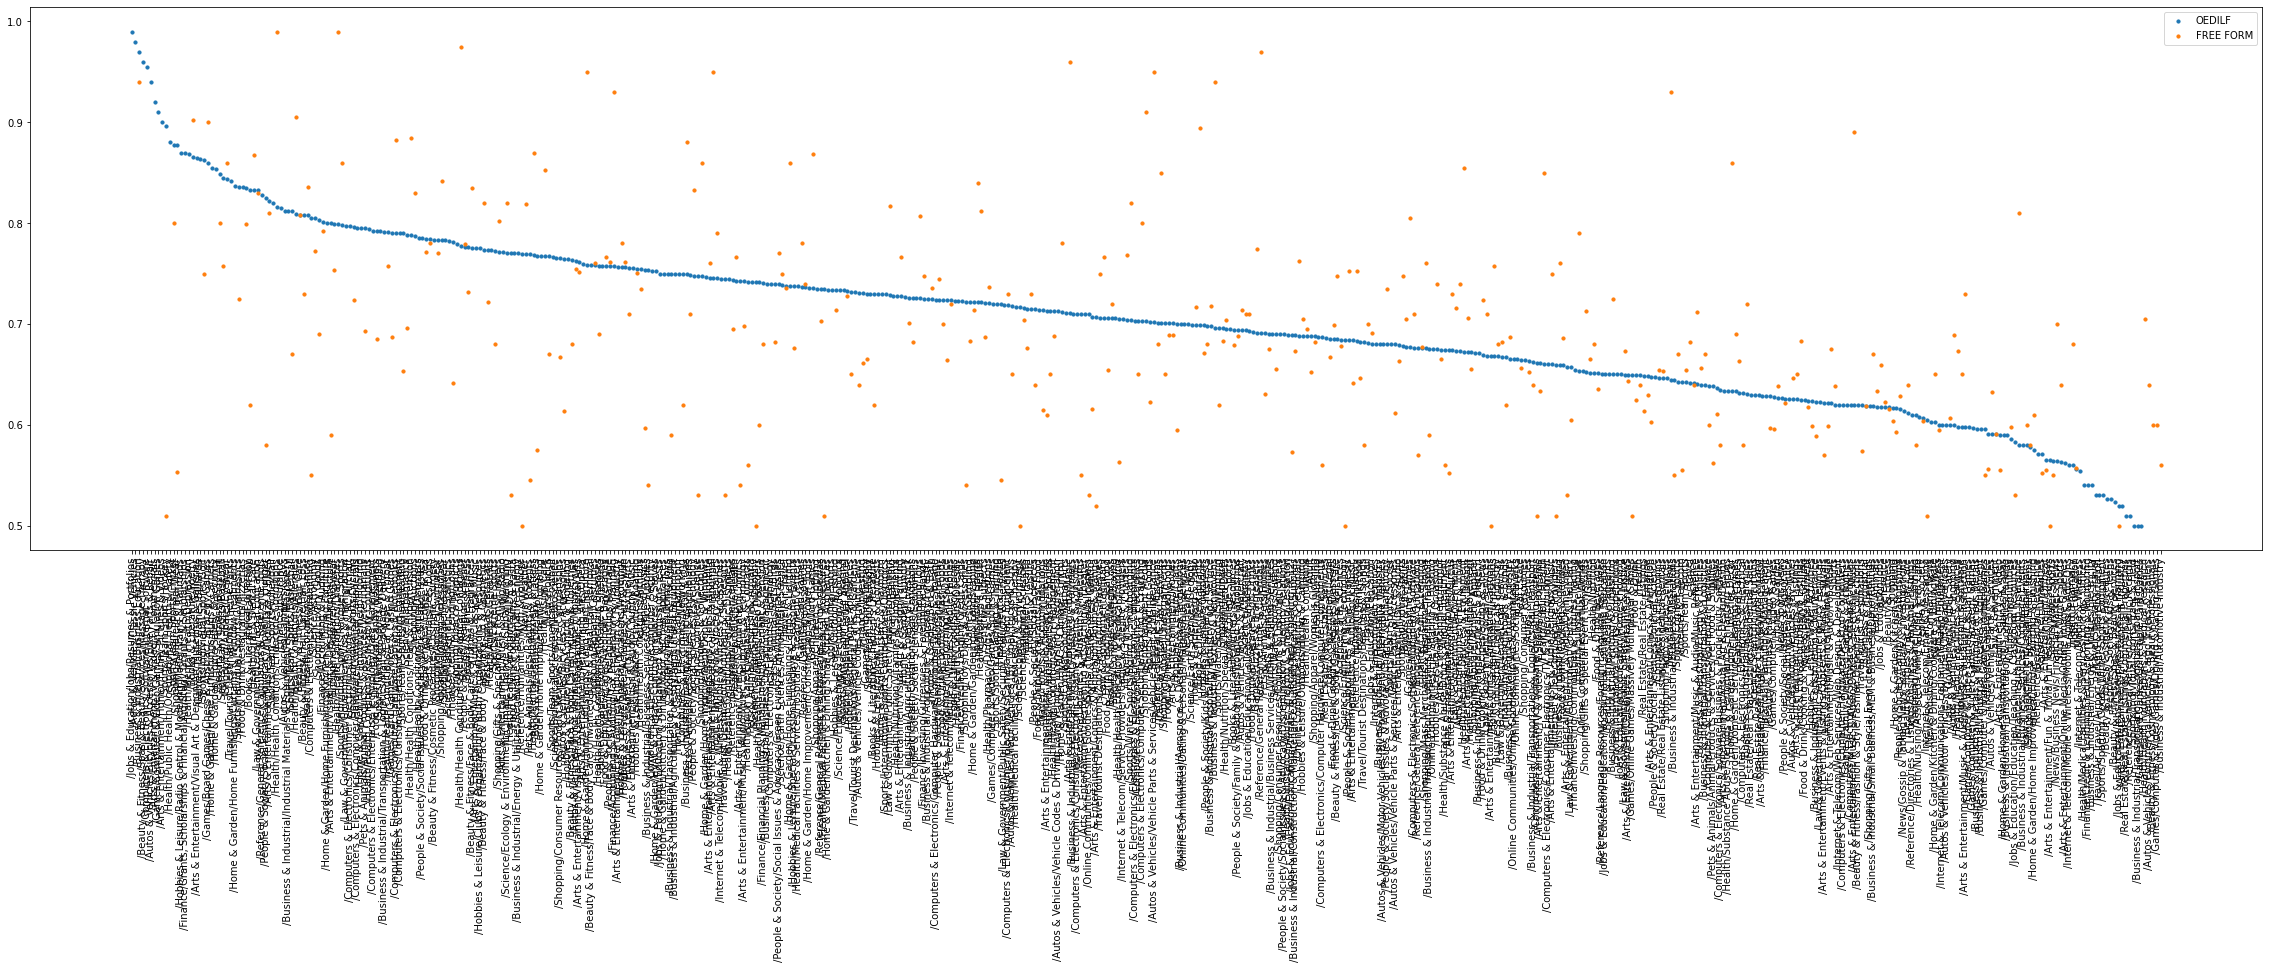

In [42]:
plt.figure(figsize=(40,10))
plt.scatter(classified_poems_df.describe().loc['mean'].sort_values(ascending=False).index, classified_poems_df.describe().loc['mean'].sort_values(ascending=False), 10)
# plt.scatter(classified_poems_df.describe().loc['mean'].index, classified_poems_df.describe().loc['min'], 2)
# plt.scatter(classified_poems_df.describe().loc['mean'].index, classified_poems_df.describe().loc['max'], 2)
plt.scatter(gen_classified_poems_df.describe().loc['mean'].sort_values(ascending=False).index, gen_classified_poems_df.describe().loc['mean'].sort_values(ascending=False), 10)
plt.legend(['OEDILF', 'FREE FORM'])
plt.xticks(rotation = 90);

In [56]:
# Identify categories and limericks in Free Form dataset but not OEDILF
free_form_cats = classified_free_form_poems_df.iloc[:, 2:].columns
oedilf_cats = classified_oedilf_poems_df.iloc[:, 2:].columns
print("Free Form Category: Number of Poems")
for c in free_form_cats:
  if c not in oedilf_cats:
    print(f"{c}: {sum(classified_free_form_poems_df[c]>0)}")

Free Form Category: Number of Poems
/Business & Industrial/Automotive Industry: 1
/Games/Computer & Video Games/Driving & Racing Games: 1
/Health/Health Foundations & Medical Research: 2
/Beauty & Fitness/Cosmetology & Beauty Professionals: 1
/Autos & Vehicles/Commercial Vehicles/Cargo Trucks & Trailers: 1


In [54]:
sum(classified_free_form_poems_df[classified_free_form_poems_df.iloc[:, 2:].columns[0]]>0)

41

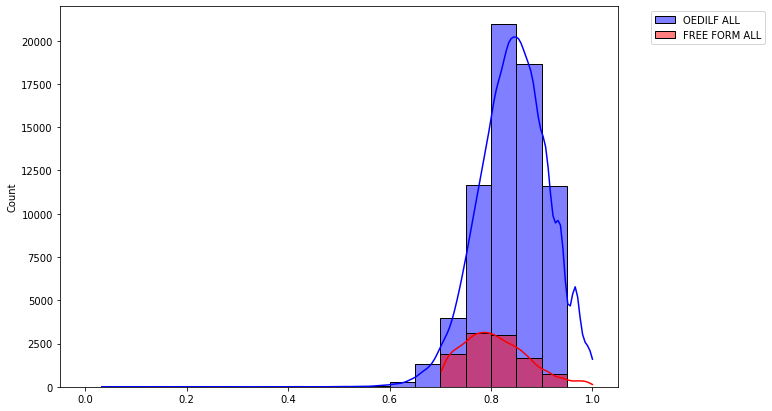

In [57]:
plt.figure(figsize=(10, 7));
sns.histplot(classified_poems_df.iloc[:, 1:].max(axis=1), bins=np.arange(0,1,.05), label='OEDILF ALL', kde=True, color='blue');
sns.histplot(gen_classified_poems_df.iloc[:, 1:].max(axis=1), bins=np.arange(0,1,.05), label='FREE FORM ALL', kde=True, color='red');
# for c in classified_poems_df.columns[1:]:
#   sns.histplot(classified_poems_df[c], bins=np.arange(0,1,.05), label=c);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [60]:
scipy.stats.ttest_ind(classified_poems_df.iloc[:, 2:].max(axis=1).dropna(), gen_classified_poems_df.iloc[:, 2:].max(axis=1).dropna(), axis=0, equal_var=False)

Ttest_indResult(statistic=4.44605587864327, pvalue=8.87579227803335e-06)

# Extras

In [ ]:
# check length of limericks
tokenizer = RegexpTokenizer(r'\w+')
for i, p in enumerate(flat_poems):
  tokens = tokenizer.tokenize(p)
  print(len(tokens))

32
31
39
30
38
29
24
34
25
27
